In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
vaccination_df = pd.read_csv('./COVID19_vaccination_doses_timeline_v202206.csv', delimiter=';')
hospitalisierung_df = pd.read_csv('./Hospitalisierung.csv', delimiter=';')
timeline_df = pd.read_csv('./CovidFaelle_Timeline.csv', delimiter=';')

In [3]:
vaccination_df = vaccination_df[['date', 'doses_administered_cumulative']]
hospitalisierung_df = hospitalisierung_df[['Meldedatum', 'IntensivBettenBelCovid19', 'NormalBettenBelCovid19']]
timeline_df = timeline_df[['Time', 'AnzahlTotTaeglich']]

In [4]:
%%capture
timeline_df['Time'] = timeline_df['Time'].str.strip('00:00:00').str.strip(' ')
timeline_df['Time'] = pd.to_datetime(timeline_df['Time'])

hospitalisierung_df['Meldedatum'] = hospitalisierung_df['Meldedatum'].str.strip('00:00:00').str.strip(' ')
hospitalisierung_df['Meldedatum'] = pd.to_datetime(hospitalisierung_df['Meldedatum'])

vaccination_df['date'] = vaccination_df['date'].str.slice(start=0, stop=10)
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])

In [5]:
timeline_df.sample(5)


,Time,AnzahlTotTaeglich
7199,2022-02-14,33
48,2020-01-03,0
2946,2020-12-16,4
6492,2021-06-12,12
988,2020-03-06,2


In [6]:
hospitalisierung_df.sample(5)

,Meldedatum,IntensivBettenBelCovid19,NormalBettenBelCovid19
258,2021-02-18,90,253
5380,2022-07-16,9,40
4742,2022-05-13,13,164
248,2021-02-17,92,264
1985,2021-10-08,9,15


In [7]:
vaccination_df.sample(5)

,date,doses_administered_cumulative
4487,2021-01-09,0
196474,2022-08-14,0
227371,2022-11-16,9264
173559,2022-06-05,420
100731,2021-10-28,0


In [8]:
hospitalisierung_df = hospitalisierung_df.groupby(['Meldedatum']).sum()
vaccination_df = vaccination_df.groupby(['date']).sum()
timeline_df = timeline_df.groupby(['Time']).sum()

In [9]:
timeline_df.index.names = ['date']
hospitalisierung_df.index.names = ['date']

In [10]:
timeline_df.sample(5)

,AnzahlTotTaeglich
date,
2022-03-13,54
2021-01-30,90
2020-03-07,2
2021-05-08,10
2021-05-25,20


In [11]:
hospitalisierung_df.sample(5)

,IntensivBettenBelCovid19,NormalBettenBelCovid19
date,,
2022-01-18,388,1662
2022-07-11,170,2344
2022-09-27,150,2448
2022-09-10,198,4198
2021-07-24,54,160


In [12]:
vaccination_df.sample(5)

,doses_administered_cumulative
date,
2021-12-19,32213054
2022-02-28,36334784
2022-10-11,39042286
2022-06-17,37096006
2021-04-12,4505052


In [13]:
merged = pd.merge(hospitalisierung_df, timeline_df, on='date', how='outer')
merged = merged.sort_values(by=['date'])

vaccine_end_of_month = vaccination_df.groupby(['date']).sum()
vaccines_month = vaccine_end_of_month.iloc[vaccine_end_of_month.reset_index().groupby(vaccine_end_of_month.index.to_period('M'))['date'].idxmax()]

merged = pd.merge(merged, vaccines_month, on='date', how='outer')

In [14]:
month_grouped = merged.groupby([merged.index.year, merged.index.month]).sum()
month_grouped['dates'] = month_grouped.index

new_col_list = ['year', 'month']
for n, col in enumerate(new_col_list):
    month_grouped[col] = month_grouped['dates'].apply(lambda date: date[n])

month_grouped = month_grouped.drop('dates', axis=1)
month_grouped["dates"] = month_grouped["year"].astype('string') + '-' + month_grouped["month"].astype('string')

del month_grouped['year']
del month_grouped['month']

In [15]:
month_grouped = month_grouped.droplevel(0)
month_grouped = month_grouped.reset_index(drop=True)
month_grouped = month_grouped.set_index('dates')

In [16]:
month_grouped.rename(columns={'IntensivBettenBelCovid19': 'Intensive_beds'}, inplace=True)
month_grouped.rename(columns={'NormalBettenBelCovid19': 'Normal_beds'}, inplace=True)
month_grouped.rename(columns={'AnzahlTotTaeglich': 'Deaths'}, inplace=True)
month_grouped.rename(columns={'doses_administered_cumulative': 'Vaccines_cumulative'}, inplace=True)

In [17]:
month_grouped_nan = month_grouped.replace(0, 'NaN')


In [18]:
month_grouped_nan.at['2020-11', 'Vaccines_cumulative'] = 0


In [19]:
month_grouped_nan_short = month_grouped_nan.drop(['2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8'])
month_grouped_nan_short.index =  pd.to_datetime(month_grouped_nan_short.index, format='%Y-%m')

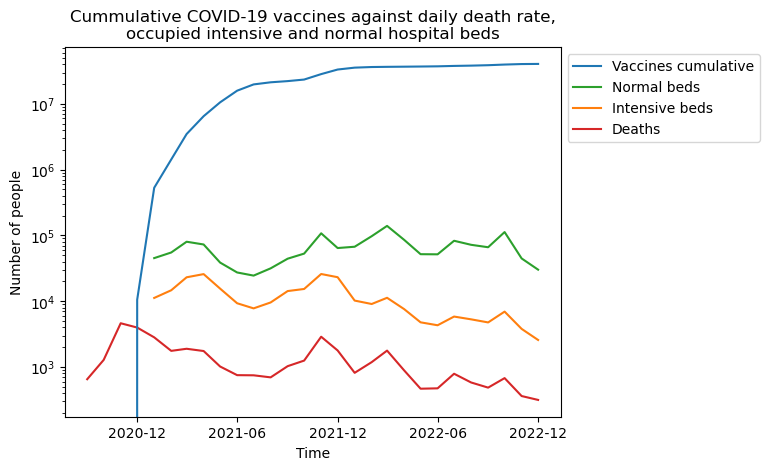

In [20]:
fig = plt.figure()
ax_nan = fig.add_subplot(111)

plt.plot(month_grouped_nan_short['Deaths'], label='Deaths', color='#d62728')
plt.plot(month_grouped_nan_short['Intensive_beds'][4:], label='Intensive beds', color='#ff7f0e')
plt.plot(month_grouped_nan_short['Normal_beds'][4:], label='Normal beds', color='#2ca02c')
plt.plot(month_grouped_nan_short['Vaccines_cumulative'][2:], label='Vaccines cumulative', color='#1f77b4')

ax_nan.set_yscale('log')

ax_nan.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(12, 6)))
ax_nan.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.ylabel('Number of people')
plt.xlabel('Time')

legend_handles, legend_labels = plt.gca().get_legend_handles_labels()
legend_order = [3,2,1,0]
plt.legend([legend_handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(1,1), loc='upper left')

plt.title(f"Cummulative COVID-19 vaccines against daily death rate,\noccupied intensive and normal hospital beds")

# plt.savefig('plot_final_andeol.png', dpi=1200, format='png', bbox_inches='tight')

plt.show()